In [5]:
import os

<h2>Tables with the phosphosite info</h2>

<p>Here, we make two tables for HMR and mouse datasets containing:<br>
    1. Coordinates of phosphosites <br>
    2. Phosphosites context identifiers <br>
    3. Location of phosphosites in ordered/disordered regions <br>
    4. Location of phosphosites in/outside phospho-islands </p>
<br>
<p>Additionally, for each dataset we construct a table containing 
    the lists of clustered phosphosites for each gene where at least
    one cluster has been identified </p>
<br>
<p>The tables will be provided as supplementary XLSX file</p>
<br>
<p>Directory: phos_tables</p>

In [20]:
def read_sitelist(sitelist_file):
    sitelist_dict = dict()
    with open(sitelist_file) as infile:
        for s in infile:
            s = s.strip().split()
            if not sitelist_dict.get(s[0]):
                sitelist_dict[s[0]] = dict()
            sitelist_dict[s[0]][eval(s[2])] = s
    return sitelist_dict

def init_nas(sitelist_dict):
    for k1 in sitelist_dict.keys():
        for k2 in sitelist_dict[k1].keys():
            sitelist_dict[k1][k2].append("NA")

def add_label(big_sitelist_dict, small_sitelist_dict, label, position):
    for k1 in small_sitelist_dict.keys():
        for k2 in small_sitelist_dict[k1].keys():
            big_sitelist_dict[k1][k2][position] = label

def print_table(final_sitelist_dict, outfile):
    with open(outfile, 'w') as outhandle:
        outhandle.write("id1\tid2\tpos\taacid\tiPTMnet_score\tmotif_type\tordered/disoredred\tin_island/individual\n")
        for k1 in final_sitelist_dict.keys():
            for k2 in final_sitelist_dict[k1].keys():
                outhandle.write('\t'.join(final_sitelist_dict[k1][k2]) + '\n')

def test1_array_len(sitelist_dict):
    len_array = dict()
    for k1 in sitelist_dict.keys():
        for k2 in sitelist_dict[k1].keys():
            l = len(sitelist_dict[k1][k2])
            if l == 6:
                print(sitelist_dict[k1][k2])
            if not len_array.get(l):
                len_array[l] = 0
            len_array[l] += 1
    return len_array

In [23]:
#HMR sites
big_sitelist_dict = read_sitelist("phos_tables/human_hmr_cons_all_mot.tsv")
d_isl_sitelist_dict = read_sitelist("phos_tables/d_human_hmr_cons_isl_mot.tsv")
d_n_isl_sitelist_dict = read_sitelist("phos_tables/d_human_hmr_cons_n_isl_mot.tsv")
d_sitelist_dict = read_sitelist("phos_tables/d_human_hmr_cons_all_mot.tsv")
o_sitelist_dict = read_sitelist("phos_tables/o_human_hmr_cons_all_mot.tsv")

In [24]:
init_nas(big_sitelist_dict)
add_label(big_sitelist_dict, d_sitelist_dict, 'd', 6)
add_label(big_sitelist_dict, o_sitelist_dict, 'o', 6)

init_nas(big_sitelist_dict)
add_label(big_sitelist_dict, d_isl_sitelist_dict, 'isl', 7)
add_label(big_sitelist_dict, d_n_isl_sitelist_dict, 'ind', 7)
print_table(big_sitelist_dict, "phos_tables/hmr_sites_list.tsv")

In [26]:
#mouse sites
big_sitelist_dict = read_sitelist("phos_tables/mouse_iptmnet_mot.tsv")
d_isl_sitelist_dict = read_sitelist("phos_tables/d_mouse_iptmnet_isl_mot.tsv")
d_n_isl_sitelist_dict = read_sitelist("phos_tables/d_mouse_iptmnet_n_isl_mot.tsv")
d_sitelist_dict = read_sitelist("phos_tables/d_mouse_iptmnet_mot.tsv")
o_sitelist_dict = read_sitelist("phos_tables/o_mouse_iptmnet_mot.tsv")

In [27]:
init_nas(big_sitelist_dict)
add_label(big_sitelist_dict, d_sitelist_dict, 'd', 6)
add_label(big_sitelist_dict, o_sitelist_dict, 'o', 6)

init_nas(big_sitelist_dict)
add_label(big_sitelist_dict, d_isl_sitelist_dict, 'isl', 7)
add_label(big_sitelist_dict, d_n_isl_sitelist_dict, 'ind', 7)
print_table(big_sitelist_dict, "phos_tables/mouse_sites_list.tsv")

<h4>Lists of phospho islands</h4>
<p>Basing on the output tables generated in phospho_islands_2.ipynb</p>

In [28]:
def make_phospho_isl_table(psite_isls_raw_file, outfile_name):
    isl_dict = dict()
    with open(psite_isls_raw_file) as inhandle, open(outfile_name, 'w') as outfile:
        outfile.write("seq_id\tisl_id\tpsite_crds\n")
        for s in inhandle:
            s = s.strip().split()
            if len(s) == 1:
                continue
            seq_id = s[0]
            if not isl_dict.get(seq_id):
                isl_id = 0
                isl_dict[seq_id] = dict()
            else:
                isl_id = max(list(isl_dict[seq_id].keys())) + 1
            isl_dict[seq_id][isl_id] = ','.join(s[1:])
            isl_id_s = seq_id + '_' + str(isl_id)
            outfile.write("{}\t{}\t{}\n".format(seq_id, isl_id_s, isl_dict[seq_id][isl_id]))
    return isl_dict

In [30]:
a = make_phospho_isl_table("psite_islands/d_human_hmr_cons_psite_isls.tsv", "phos_tables/hmr_psite_islands.tsv")
b = make_phospho_isl_table("psite_islands/d_mouse_iptm_psite_isls.tsv", "phos_tables/mouse_psite_islands.tsv")

<h2>Differences between clustered and individual phosphosite mutation patterns</h2>

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import ast
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages

In [18]:
def mutdict_colsum(mutdict, c):
    colsum = 0
    for c1 in mutdict[c].keys():
        colsum += mutdict[c][c1]
    return colsum


def mutfreq_isl_ind_compar(aacid_p, aacid, mutdict1, mutdict2, phospho_aas):
    if aacid in phospho_aas:
        pX2Y_1 = mutdict1['p' + aacid_p]['p' + aacid]
        pX2Y_2 = mutdict2['p' + aacid_p]['p' + aacid]
    else:
        pX2Y_1 = mutdict1['p' + aacid_p][aacid]
        pX2Y_2 = mutdict2['p' + aacid_p][aacid]
    
    colsum_1 = mutdict_colsum(mutdict1, 'p' + aacid_p)
    colsum_2 = mutdict_colsum(mutdict2, 'p' + aacid_p)
    
    if min(pX2Y_1, pX2Y_2, colsum_1, colsum_2) < 20:
        oddsratio, pvalue = stats.fisher_exact([[pX2Y_1, colsum_1], [pX2Y_2, colsum_2]])
        FET = True
    else:
        g, pvalue, dof, expctd = stats.chi2_contingency([[pX2Y_1, colsum_1], [pX2Y_2, colsum_2]])
        FET = False
    
    pvalue *= 19
    
    if pvalue < 0.05:
    
        print("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}".format(aacid_p,
                                                      aacid,
                                                      pX2Y_1, 
                                                      colsum_1, 
                                                      pX2Y_2, 
                                                      colsum_2, 
                                                      round(float(pX2Y_1)/colsum_1, 6), 
                                                      round(float(pX2Y_2)/colsum_2, 6),
                                                      round((float(pX2Y_1)/colsum_1)/(float(pX2Y_2)/colsum_2), 6),
                                                      pvalue))
    
    return (float(pX2Y_1)/colsum_1)/(float(pX2Y_2)/colsum_2), pvalue


def plot_differences(mutdict1, mutdict2, aacid_p, phospho_aas, title):
    aa_list = list("STYDENQKRHGAVLIFWMCP")
    pval_arr = []
    R_arr = []
    
    plt_aas = []
    
    for aa in aa_list:
        if aacid_p == aa:
            continue
        plt_aas.append(aa)
        R, p = mutfreq_isl_ind_compar(aacid_p, aa, mutdict1, mutdict2, phospho_aas)
        pval_arr.append(p)
        R_arr.append(R)
    
    plt.scatter(plt_aas, R_arr)
    plt.savefig(title)
    print(R_arr)
    for i in pval_arr:
        print(i)
    
    plt.show()

S	E	180	7195	125	7558	0.025017	0.016539	1.51265	0.009334880816750825
[1.058461682874061, 0.7307490104843339, 1.307228785421975, 1.5126504517025714, 0.9767563158652305, 1.3186521372702673, 1.0756625434329397, 0.9866120963376195, 0.9740552151115043, 1.0206907414280788, 0.9670653303052664, 1.05045170257123, 1.0581756121489596, 1.1663103462371744, 0.8620948455584578, 1.0504517025712299, 1.096123515726501, 0.8926118094387654, 0.9030829436134183]
4.949458659543224
0.7176872167920418
0.47291886253190746
0.009334880816750825
12.574676849900936
1.0335916560069665
11.56691471290409
16.948680744973647
17.17476919652422
13.18511089046275
9.72583143216254
13.741278708947114
7.299299699593203
4.15165414767925
1.9817333944161115
17.501941062227367
13.94241427508627
2.8474636745824107
0.540923124484518


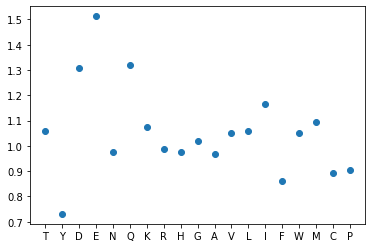

None
T	I	177	2574	193	1758	0.068765	0.109784	0.626363	0.0003479602100013979
[1.0495021133319007, 2.048951048951049, 0.9485884485884486, 0.7114413364413364, 0.917759324009324, 1.6143250688705235, 1.170829170829171, 0.8916731416731417, 1.0244755244755244, 0.7834224598930482, 1.0965089597902098, 1.0465072561846755, 0.7588707588707589, 0.6263632740316678, 0.7450731087094723, 0.25611888111888115, 0.8065712065712066, 0.7450731087094723, 1.3707434756385806]
9.695889625399584
9.231761574319847
16.66259758500641
5.63536415496456
12.724319582967173
4.535118148327562
10.059431243116254
13.09182282538492
19.0
6.857063687082183
3.0549244381239866
16.124227577263433
3.3082418338114907
0.0003479602100013979
10.000797213024224
1.1325280834776217
2.479517948542823
10.000797213024224
0.06934101042955296


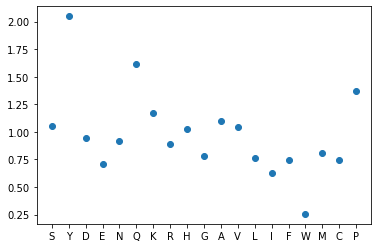

None
[0.9547894302229563, 0.541907514450867, 1.0160765895953758, 0.722543352601156, 1.083815028901734, 3.2514450867052025, 5.41907514450867, 0.4241015330485047, 1.0509721492380453, 0.8429672447013488, 1.083815028901734, 0.361271676300578, 1.0063996696944673, 0.5002223210315696, 1.083815028901734, 1.8966763005780347, 0.361271676300578, 1.1887003542793213, 0.9483381502890174]
17.845741926032094
7.403480310790832
19.0
11.566354455699084
19.0
1.5486952460397028
2.126547197008794
0.5726780178605921
16.502648014647512
15.281710375282518
19.0
2.8162146255943026
19.0
3.2531046426866412
13.895476162472855
7.031970620941063
11.881450532631337
7.9244025245778404
19.0


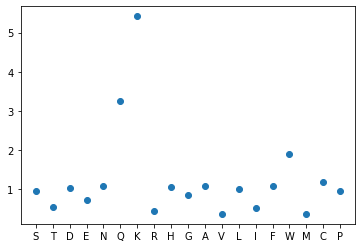

None


In [19]:
hmr_cons_dr_isl = {'mutdict': {'pS': {'A': 893, 'C': 328, 'E': 180, 'G': 926, 'pT': 925, 'F': 238, 'I': 151, 'H': 102, 'K': 128, 'pY': 80, 'M': 48, 'L': 548, 'N': 835, 'Q': 118, 'P': 1005, 'R': 340, 'W': 38, 'V': 144, 'D': 168}, 'pT': {'A': 822, 'pS': 650, 'C': 12, 'E': 25, 'D': 25, 'G': 39, 'F': 12, 'I': 177, 'H': 18, 'K': 60, 'pY': 6, 'M': 124, 'L': 60, 'N': 86, 'Q': 26, 'P': 287, 'R': 47, 'W': 3, 'V': 95}, 'pY': {'A': 7, 'pS': 37, 'C': 68, 'E': 6, 'D': 15, 'pT': 4, 'F': 70, 'I': 6, 'H': 64, 'K': 5, 'M': 1, 'L': 13, 'N': 8, 'G': 7, 'P': 7, 'R': 9, 'Q': 9, 'W': 7, 'V': 3}, 'A': {'pS': 112, 'pT': 231, 'pY': 3, 'C': 3418, 'E': 25421, 'D': 17315, 'G': 52418, 'F': 3039, 'I': 9327, 'H': 2529, 'K': 5520, 'M': 6703, 'L': 13685, 'N': 4470, 'Q': 5644, 'P': 53615, 'S': 73481, 'R': 10194, 'T': 178900, 'W': 1024, 'V': 124760, 'Y': 1047}, 'C': {'pS': 28, 'pT': 1, 'pY': 17, 'A': 1895, 'E': 504, 'D': 852, 'G': 9824, 'F': 3846, 'I': 538, 'H': 5035, 'K': 440, 'M': 267, 'L': 2322, 'N': 953, 'Q': 801, 'P': 1623, 'S': 15035, 'R': 10364, 'T': 939, 'W': 2285, 'V': 1254, 'Y': 12689}, 'E': {'A': 38421, 'pS': 24, 'C': 1308, 'D': 122737, 'G': 63144, 'F': 1802, 'I': 2510, 'H': 3729, 'K': 67133, 'M': 2511, 'L': 6953, 'pT': 3, 'N': 6979, 'Q': 46496, 'P': 8538, 'S': 11650, 'R': 13283, 'T': 8324, 'W': 1102, 'V': 15876, 'Y': 1317}, 'D': {'pS': 21, 'pT': 5, 'pY': 2, 'A': 19266, 'C': 1315, 'E': 94215, 'G': 43701, 'F': 1040, 'I': 1701, 'H': 11435, 'K': 4176, 'M': 764, 'L': 2665, 'N': 47540, 'Q': 3453, 'P': 4155, 'S': 13127, 'R': 3846, 'T': 4819, 'W': 331, 'V': 7717, 'Y': 4753}, 'G': {'A': 61219, 'pS': 100, 'C': 8926, 'E': 55042, 'D': 43013, 'pT': 6, 'F': 1431, 'I': 2498, 'H': 3555, 'K': 6781, 'M': 1701, 'L': 5044, 'N': 7900, 'Q': 6136, 'P': 8358, 'S': 91930, 'R': 58908, 'T': 8503, 'W': 3683, 'V': 23640, 'Y': 935}, 'F': {'A': 1812, 'pS': 4, 'C': 5619, 'E': 584, 'D': 454, 'G': 986, 'I': 5349, 'H': 1038, 'K': 524, 'pY': 6, 'M': 653, 'L': 35008, 'N': 509, 'Q': 521, 'P': 2252, 'S': 13390, 'R': 996, 'T': 1094, 'W': 880, 'V': 7343, 'Y': 7894}, 'I': {'pS': 7, 'pT': 27, 'pY': 1, 'A': 6222, 'C': 553, 'E': 1108, 'D': 924, 'G': 1949, 'F': 5865, 'H': 684, 'K': 2466, 'M': 21582, 'L': 29498, 'N': 3954, 'Q': 748, 'P': 2055, 'S': 8036, 'R': 3082, 'T': 33036, 'W': 205, 'V': 75199, 'Y': 559}, 'H': {'pS': 13, 'pT': 2, 'pY': 3, 'A': 2328, 'C': 8122, 'E': 1850, 'D': 5367, 'G': 3038, 'F': 1702, 'I': 811, 'K': 1650, 'M': 362, 'L': 11771, 'N': 10255, 'Q': 33325, 'P': 22069, 'S': 6861, 'R': 37184, 'T': 1946, 'W': 468, 'V': 1099, 'Y': 20599}, 'K': {'pS': 2, 'pT': 13, 'pY': 4, 'A': 6950, 'C': 950, 'E': 46477, 'D': 4142, 'G': 7456, 'F': 1291, 'I': 4761, 'H': 2851, 'M': 6625, 'L': 4946, 'N': 29328, 'Q': 38908, 'P': 5791, 'S': 11206, 'R': 110511, 'T': 25240, 'W': 709, 'V': 3672, 'Y': 909}, 'M': {'pS': 1, 'pT': 24, 'pY': 1, 'A': 5101, 'C': 379, 'E': 1447, 'D': 405, 'G': 1773, 'F': 797, 'I': 21021, 'H': 368, 'K': 4521, 'L': 26943, 'N': 529, 'Q': 1010, 'P': 1763, 'S': 2188, 'R': 5161, 'T': 23371, 'W': 399, 'V': 38528, 'Y': 255}, 'L': {'A': 10556, 'pS': 38, 'C': 3548, 'E': 3804, 'D': 1572, 'G': 4932, 'F': 42013, 'I': 23149, 'H': 8123, 'K': 3118, 'M': 21366, 'pT': 3, 'N': 1536, 'Q': 17028, 'P': 58718, 'S': 30611, 'R': 16288, 'T': 6423, 'W': 6038, 'V': 51978, 'Y': 2007}, 'N': {'pS': 151, 'pT': 30, 'pY': 5, 'A': 4726, 'C': 1501, 'E': 4816, 'D': 38506, 'G': 10354, 'F': 900, 'I': 6539, 'H': 24518, 'K': 24462, 'M': 900, 'L': 2314, 'Q': 3400, 'P': 3203, 'S': 106847, 'R': 5851, 'T': 24780, 'W': 244, 'V': 2008, 'Y': 4009}, 'Q': {'A': 7068, 'pS': 18, 'pT': 3, 'E': 35484, 'D': 3115, 'G': 7017, 'F': 1184, 'C': 1383, 'H': 43742, 'K': 26363, 'M': 1485, 'L': 23890, 'N': 2937, 'P': 57225, 'S': 9216, 'R': 62056, 'T': 4357, 'W': 4430, 'V': 3055, 'Y': 1781, 'I': 1302}, 'P': {'pS': 181, 'pT': 54, 'pY': 1, 'A': 77443, 'C': 3759, 'E': 6594, 'D': 3331, 'G': 9356, 'F': 4660, 'I': 3426, 'H': 17664, 'K': 4315, 'M': 2173, 'L': 112917, 'N': 2582, 'Q': 30345, 'S': 160026, 'R': 25221, 'T': 43706, 'W': 1336, 'V': 8798, 'Y': 1473}, 'S': {'A': 86922, 'C': 32616, 'E': 8174, 'D': 11150, 'G': 93145, 'F': 24845, 'I': 13010, 'H': 10046, 'K': 8931, 'M': 2840, 'L': 46428, 'N': 89448, 'Q': 7118, 'P': 109372, 'R': 37998, 'T': 79759, 'W': 3367, 'V': 11520, 'Y': 7928}, 'R': {'A': 8105, 'pS': 8, 'C': 14023, 'E': 7592, 'D': 2336, 'G': 43052, 'F': 1442, 'I': 3538, 'H': 30703, 'K': 70642, 'M': 3663, 'L': 14411, 'pT': 4, 'N': 3729, 'Q': 58317, 'P': 16638, 'S': 25981, 'T': 12581, 'W': 13299, 'V': 3585, 'Y': 1474}, 'T': {'A': 143908, 'C': 1670, 'E': 5080, 'D': 3456, 'G': 7269, 'F': 1836, 'I': 48405, 'H': 2335, 'K': 11711, 'M': 28858, 'L': 9229, 'N': 17565, 'Q': 3350, 'P': 45591, 'S': 78987, 'R': 11204, 'W': 554, 'V': 19497, 'Y': 895}, 'W': {'A': 415, 'pS': 1, 'C': 2613, 'E': 436, 'D': 119, 'G': 2663, 'F': 547, 'I': 156, 'H': 241, 'K': 334, 'M': 175, 'L': 2672, 'pT': 1, 'N': 104, 'Q': 1942, 'P': 567, 'S': 1558, 'R': 5931, 'T': 292, 'V': 370, 'Y': 424}, 'V': {'A': 82502, 'pS': 16, 'C': 1541, 'E': 11429, 'D': 4965, 'G': 26491, 'F': 6195, 'I': 74966, 'H': 930, 'K': 2601, 'M': 37710, 'L': 41447, 'pT': 12, 'N': 1442, 'Q': 1956, 'P': 5159, 'S': 7809, 'R': 3688, 'T': 16036, 'W': 783, 'Y': 673}, 'Y': {'A': 773, 'C': 12794, 'E': 597, 'D': 2798, 'G': 935, 'F': 11145, 'I': 665, 'H': 12738, 'K': 433, 'M': 231, 'L': 2122, 'N': 2598, 'Q': 896, 'P': 1167, 'S': 6071, 'R': 1357, 'T': 706, 'W': 616, 'V': 690}}, 'sitenumdict': {'pS': 20376, 'pT': 4613, 'pY': 1494, 'A': 366801, 'C': 82495, 'E': 480569, 'D': 256683, 'G': 371821, 'F': 100523, 'I': 122379, 'H': 127187, 'K': 359973, 'M': 103818, 'L': 380909, 'N': 170435, 'Q': 286554, 'P': 453150, 'S': 552219, 'R': 326277, 'T': 274884, 'W': 29170, 'V': 203822, 'Y': 72900}}
hmr_cons_dr_n_isl = {'mutdict': {'pS': {'A': 970, 'C': 386, 'E': 125, 'pT': 918, 'G': 953, 'F': 290, 'I': 136, 'H': 110, 'K': 125, 'pY': 115, 'M': 46, 'L': 544, 'N': 898, 'Q': 94, 'P': 1169, 'R': 362, 'W': 38, 'V': 144, 'D': 135}, 'pT': {'A': 512, 'pS': 423, 'C': 11, 'E': 24, 'D': 18, 'G': 34, 'F': 11, 'I': 193, 'H': 12, 'K': 35, 'pY': 2, 'M': 105, 'L': 54, 'N': 64, 'Q': 11, 'P': 143, 'R': 36, 'W': 8, 'V': 62}, 'pY': {'A': 7, 'pS': 42, 'C': 62, 'G': 9, 'E': 9, 'D': 16, 'pT': 8, 'F': 70, 'I': 13, 'H': 66, 'K': 1, 'M': 3, 'L': 14, 'N': 8, 'Q': 3, 'P': 8, 'R': 23, 'W': 4, 'V': 9}, 'A': {'pS': 91, 'pT': 140, 'E': 25421, 'D': 17315, 'G': 52418, 'F': 3039, 'I': 9327, 'H': 2529, 'K': 5520, 'M': 6703, 'L': 13685, 'N': 4470, 'Q': 5644, 'P': 53615, 'S': 73502, 'R': 10194, 'T': 178991, 'W': 1024, 'V': 124760, 'Y': 1050, 'C': 3418}, 'C': {'A': 1895, 'pS': 31, 'E': 504, 'D': 852, 'G': 9824, 'F': 3846, 'I': 538, 'H': 5035, 'K': 440, 'pY': 20, 'M': 267, 'L': 2322, 'N': 953, 'Q': 801, 'P': 1623, 'S': 15032, 'R': 10364, 'T': 940, 'W': 2285, 'V': 1254, 'Y': 12686}, 'E': {'pS': 19, 'pT': 4, 'pY': 2, 'A': 38421, 'C': 1308, 'D': 122737, 'G': 63144, 'F': 1802, 'I': 2510, 'H': 3729, 'K': 67133, 'M': 2511, 'L': 6953, 'N': 6979, 'Q': 46496, 'P': 8538, 'S': 11655, 'R': 13283, 'T': 8323, 'W': 1102, 'V': 15876, 'Y': 1315}, 'D': {'pS': 7, 'pT': 5, 'pY': 2, 'A': 19266, 'C': 1315, 'E': 94215, 'G': 43701, 'F': 1040, 'I': 1701, 'H': 11435, 'K': 4176, 'M': 764, 'L': 2665, 'N': 47540, 'Q': 3453, 'P': 4155, 'S': 13141, 'R': 3846, 'T': 4819, 'W': 331, 'V': 7717, 'Y': 4753}, 'G': {'A': 61219, 'pS': 143, 'C': 8926, 'E': 55042, 'D': 43013, 'pT': 2, 'F': 1431, 'I': 2498, 'H': 3555, 'K': 6781, 'M': 1701, 'L': 5044, 'N': 7900, 'Q': 6136, 'P': 8358, 'S': 91887, 'R': 58908, 'T': 8507, 'W': 3683, 'V': 23640, 'Y': 935}, 'F': {'pS': 9, 'pT': 3, 'pY': 10, 'A': 1812, 'C': 5619, 'E': 584, 'D': 454, 'G': 986, 'I': 5349, 'H': 1038, 'K': 524, 'M': 653, 'L': 35008, 'N': 509, 'Q': 521, 'P': 2252, 'S': 13385, 'R': 996, 'T': 1091, 'W': 880, 'V': 7343, 'Y': 7890}, 'I': {'pS': 11, 'pT': 32, 'pY': 1, 'A': 6222, 'C': 553, 'E': 1108, 'D': 924, 'G': 1949, 'F': 5865, 'H': 684, 'K': 2466, 'M': 21582, 'L': 29498, 'N': 3954, 'Q': 748, 'P': 2055, 'S': 8032, 'R': 3082, 'T': 33031, 'W': 205, 'V': 75199, 'Y': 559}, 'H': {'A': 2328, 'pS': 2, 'C': 8122, 'E': 1850, 'D': 5367, 'G': 3038, 'F': 1702, 'I': 811, 'K': 1650, 'pY': 5, 'M': 362, 'L': 11771, 'N': 10255, 'Q': 33325, 'P': 22069, 'S': 6872, 'R': 37184, 'T': 1948, 'W': 468, 'V': 1099, 'Y': 20597}, 'K': {'pS': 7, 'pT': 7, 'pY': 1, 'A': 6950, 'C': 950, 'E': 46477, 'D': 4142, 'G': 7456, 'F': 1291, 'I': 4761, 'H': 2851, 'M': 6625, 'L': 4946, 'N': 29328, 'Q': 38908, 'P': 5791, 'S': 11201, 'R': 110511, 'T': 25246, 'W': 709, 'V': 3672, 'Y': 912}, 'M': {'A': 5101, 'pS': 2, 'C': 379, 'E': 1447, 'D': 405, 'G': 1773, 'F': 797, 'I': 21021, 'H': 368, 'K': 4521, 'L': 26943, 'pT': 16, 'N': 529, 'Q': 1010, 'P': 1763, 'S': 2187, 'R': 5161, 'T': 23379, 'W': 399, 'V': 38528, 'Y': 256}, 'L': {'A': 10556, 'pS': 32, 'C': 3548, 'E': 3804, 'D': 1572, 'G': 4932, 'F': 42013, 'I': 23149, 'H': 8123, 'K': 3118, 'M': 21366, 'pT': 4, 'N': 1536, 'Q': 17028, 'P': 58718, 'S': 30617, 'R': 16288, 'T': 6422, 'W': 6038, 'V': 51978, 'Y': 2007}, 'N': {'pS': 128, 'pT': 30, 'pY': 5, 'A': 4726, 'C': 1501, 'E': 4816, 'D': 38506, 'G': 10354, 'F': 900, 'I': 6539, 'H': 24518, 'K': 24462, 'M': 900, 'L': 2314, 'Q': 3400, 'P': 3203, 'S': 106870, 'R': 5851, 'T': 24780, 'W': 244, 'V': 2008, 'Y': 4009}, 'Q': {'A': 7068, 'pS': 9, 'C': 1383, 'E': 35484, 'D': 3115, 'G': 7017, 'F': 1184, 'I': 1302, 'H': 43742, 'K': 26363, 'M': 1485, 'L': 23890, 'pT': 3, 'N': 2937, 'P': 57225, 'S': 9225, 'R': 62056, 'T': 4357, 'W': 4430, 'V': 3055, 'Y': 1781}, 'P': {'A': 77443, 'pS': 181, 'C': 3759, 'E': 6594, 'D': 3331, 'G': 9356, 'F': 4660, 'I': 3426, 'H': 17664, 'K': 4315, 'M': 2173, 'L': 112917, 'pT': 30, 'N': 2582, 'Q': 30345, 'S': 160026, 'R': 25221, 'T': 43730, 'W': 1336, 'V': 8798, 'Y': 1474}, 'S': {'A': 86845, 'C': 32558, 'E': 8229, 'D': 11183, 'G': 93118, 'F': 24793, 'I': 13025, 'H': 10038, 'K': 8934, 'M': 2842, 'L': 46432, 'N': 89385, 'Q': 7142, 'P': 109208, 'R': 37976, 'T': 79766, 'W': 3367, 'V': 11520, 'Y': 7893}, 'R': {'pS': 21, 'pT': 14, 'pY': 1, 'A': 8105, 'C': 14023, 'E': 7592, 'D': 2336, 'G': 43052, 'F': 1442, 'I': 3538, 'H': 30703, 'K': 70642, 'M': 3663, 'L': 14411, 'N': 3729, 'Q': 58317, 'P': 16638, 'S': 25968, 'T': 12571, 'W': 13299, 'V': 3585, 'Y': 1473}, 'T': {'A': 144218, 'C': 1671, 'E': 5081, 'D': 3463, 'G': 7274, 'F': 1837, 'I': 48389, 'H': 2341, 'K': 11736, 'M': 28877, 'L': 9235, 'N': 17587, 'Q': 3365, 'P': 45735, 'S': 79214, 'R': 11215, 'W': 549, 'V': 19530, 'Y': 899}, 'W': {'A': 415, 'pS': 2, 'C': 2613, 'E': 436, 'D': 119, 'G': 2663, 'F': 547, 'I': 156, 'H': 241, 'K': 334, 'M': 175, 'L': 2672, 'N': 104, 'Q': 1942, 'P': 567, 'S': 1557, 'R': 5931, 'T': 293, 'V': 370, 'Y': 424}, 'V': {'pS': 11, 'pT': 9, 'pY': 2, 'A': 82502, 'C': 1541, 'E': 11429, 'D': 4965, 'G': 26491, 'F': 6195, 'I': 74966, 'H': 930, 'K': 2601, 'M': 37710, 'L': 41447, 'N': 1442, 'Q': 1956, 'P': 5159, 'S': 7814, 'R': 3688, 'T': 16039, 'W': 783, 'Y': 671}, 'Y': {'A': 773, 'C': 12800, 'E': 594, 'D': 2797, 'G': 933, 'F': 11145, 'I': 658, 'H': 12736, 'K': 437, 'M': 229, 'L': 2121, 'N': 2598, 'Q': 902, 'P': 1166, 'S': 6066, 'R': 1343, 'T': 702, 'W': 619, 'V': 684}}, 'sitenumdict': {'pS': 13316, 'pT': 2404, 'pY': 1249, 'A': 366802, 'C': 82495, 'E': 480569, 'D': 256682, 'G': 371821, 'F': 100523, 'I': 122379, 'H': 127186, 'K': 359973, 'M': 103818, 'L': 380909, 'N': 170435, 'Q': 286554, 'P': 453149, 'S': 559279, 'R': 326277, 'T': 277093, 'W': 29170, 'V': 203821, 'Y': 73145}}

mutdict1 = hmr_cons_dr_isl["mutdict"]
mutdict2 = hmr_cons_dr_n_isl["mutdict"]

print(plot_differences(mutdict1, mutdict2, 'S', "STY", "human_ind_vs_isl_S.pdf"))
print(plot_differences(mutdict1, mutdict2, 'T', "STY", "human_ind_vs_isl_T.pdf"))
print(plot_differences(mutdict1, mutdict2, 'Y', "STY", "human_ind_vs_isl_Y.pdf"))